# Clustering Examples

In [36]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
from scipy import sparse
from matplotlib.lines import Line2D


import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [37]:
print("Reference: Dorin Comaniciu and Peter Meer, 'Mean Shift: A robust approach toward feature space analysis")
print('IEEE Transactions on Pattern Analysis and Machine Intelligence. 2002. pp. 603-619.')

Reference: Dorin Comaniciu and Peter Meer, 'Mean Shift: A robust approach toward feature space analysis
IEEE Transactions on Pattern Analysis and Machine Intelligence. 2002. pp. 603-619.


In [38]:
categories = ['alt.atheism','comp.graphics','rec.autos','sci.space']
data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers','footers','quotes'))
docs, labels = data.data, data.target
print(f"Documents: {len(docs)}, Classes: {len(set(labels))}")

stemmer = PorterStemmer()
stop = set(stopwords.words('english'))

def tokenize(text):
    tokens = nltk.word_tokenize(text.lower())
    return [stemmer.stem(w) for w in tokens if w.isalpha() and w not in stop]

Documents: 3749, Classes: 4


In [39]:
tfidf = TfidfVectorizer(tokenizer=tokenize, max_df=0.7, min_df=5)
X_tfidf = tfidf.fit_transform(docs)
nonzero = np.array(X_tfidf.sum(axis=1)).ravel() > 0
X_tfidf = X_tfidf[nonzero]
labels_filtered = np.array(labels)[nonzero]


svd = TruncatedSVD(n_components=100, random_state=42)
X_tfidf_svd = svd.fit_transform(X_tfidf)

print(X_tfidf.shape, X_tfidf_svd.shape, labels_filtered.shape)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3614, 5203) (3614, 100) (3614,)


In [40]:
def cluster_and_evaluate(X, algo_name, y):
    X_dense = X.toarray() if sparse.issparse(X) else X

    if algo_name == 'kmeans':
        preds = KMeans(n_clusters=4, random_state=42).fit_predict(X)
        sil = silhouette_score(X, preds, metric='cosine')
    else:
        preds = AgglomerativeClustering(n_clusters=4, metric='cosine', linkage='single').fit_predict(X_dense)
        sil = silhouette_score(X_dense, preds, metric='cosine')

    nmi = normalized_mutual_info_score(y, preds)
    cm = contingency_matrix(y, preds)
    purity = cm.max(axis=0).sum() / len(y)
    return preds, sil, nmi, purity

# 5️⃣ Run experiments
for X,name in [(X_tfidf, 'TF-IDF'), (X_tfidf_svd, 'TF-IDF+SVD')]:
    for algo in ['kmeans','agglo']:
        _, sil, nmi, purity = cluster_and_evaluate(X, algo, labels_filtered)
        results.append((name, algo, sil, nmi, purity))

pd.DataFrame(results, columns=['Features','Algorithm','Silhouette','NMI','Purity'])

,Features,Algorithm,Silhouette,NMI,Purity
0,TF-IDF,kmeans,0.010773,0.433839,0.672662
1,TF-IDF,agglo,-0.008241,0.001681,0.264527
2,TF-IDF+SVD,kmeans,0.041939,0.405978,0.630603
3,TF-IDF+SVD,agglo,-0.038794,0.001671,0.264250
4,TF-IDF,kmeans,0.010773,0.433839,0.672662
5,TF-IDF,agglo,-0.008241,0.001681,0.264527
6,TF-IDF+SVD,kmeans,0.041939,0.405978,0.630603
7,TF-IDF+SVD,agglo,-0.038794,0.001671,0.264250


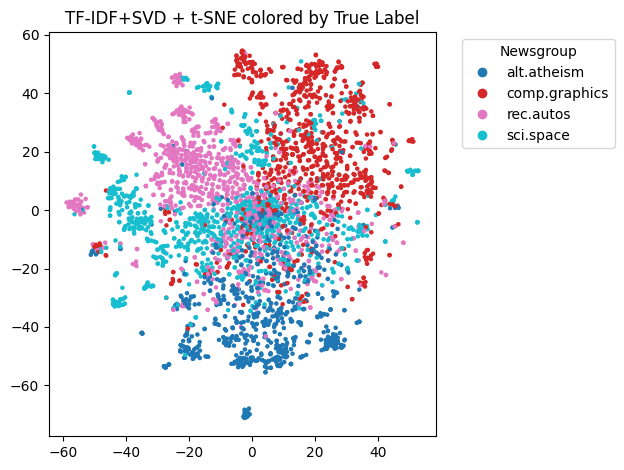

In [42]:
from matplotlib.lines import Line2D

# Compute projection
proj = TSNE(n_components=2, random_state=42).fit_transform(X_tfidf_svd)

# Plot scatter
plt.figure()
scatter = plt.scatter(proj[:,0], proj[:,1], c=labels_filtered, cmap='tab10', s=5)
plt.title("TF‑IDF+SVD + t‑SNE colored by True Label")

# Build legend with matching colors
handles = []
for label in np.unique(labels_filtered):
    color = scatter.cmap(scatter.norm(label))
    handles.append(Line2D([0], [0], marker='o', color=color, linestyle='', label=data.target_names[label]))

plt.legend(handles=handles, title="Newsgroup", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()